In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from IPython.display import clear_output

sys.path.append('../')

from dataset import Pipeline, B, V, F
from dataset.models.tf import TFModel, FasterRCNN
from dataset.opensets import MNIST
from detection_mnist import DetectionMnist

In [2]:
IMAGE_SHAPE = (128, 128)
MNIST_PER_IMAGE = (5, 15)
RESIZE_TO = (20, 20)
ANCHORS_BATCH_SIZE = 16

BATCH_SIZE = 10

In [3]:
mnist = MNIST(batch_class=DetectionMnist)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz   
C:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz




In [4]:
# feed_dict = {'images': B('images'),
#              'anchors': B('anchors'),
#              'anchors_cls': B('clsf'),
#              'anchors_reg': B('reg'),
#              'anchors_batch': B('anchor_batch'),
#              }    

feed_dict = {'images': B('images'),
             'labels': B('labels'),
             'bboxes': B('bboxes'),
             }    

feed_dict_rpn = {**feed_dict,
                'train_mode': True}

feed_dict_rcn = {**feed_dict,
                'train_mode': False}

In [5]:
placeholder_config = {'images': {'shape': IMAGE_SHAPE + (1,),
                                 'dtype': 'float32'}}

In [6]:
rpn_config = {'batch_size': F(lambda batch: len(batch.data.images)),
              'inputs': placeholder_config,
              'input_block/inputs': 'images',
              'batch_norm': {'momentum': 0.1},
              'map_shape': [],
              'loss': None,
              'optimizer': 'Adam'}

In [7]:
train_rpn = (mnist.train.p
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', FasterRCNN, 'FasterRCNN', config=rpn_config)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=MNIST_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rpn, 
                          fetches='loss', 
                          save_to=V('loss'), mode='a'))

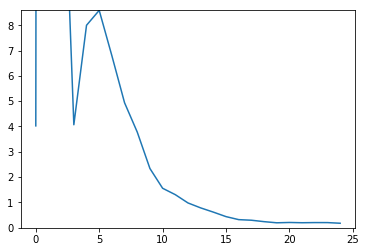

In [8]:
for i in range(25):
    train_rpn.next_batch(BATCH_SIZE)
    
    clear_output(True)
    current_max = np.max(train_rpn.get_variable('loss')[-20:])
    plt.plot(train_rpn.get_variable('loss'))
    plt.ylim([0,current_max])
    plt.show()

In [9]:
train_rcn = (mnist.train.p
            .init_variable('rpn_loss', init_on_each_run=list)
            .init_variable('rcn_loss', init_on_each_run=list)
            .import_model('FasterRCNN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=MNIST_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rpn, 
                          fetches=['loss'], 
                          save_to=[V('rpn_loss')], mode='a')
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rcn, 
                          fetches=['loss'], 
                          save_to=[V('rcn_loss')], mode='a'))

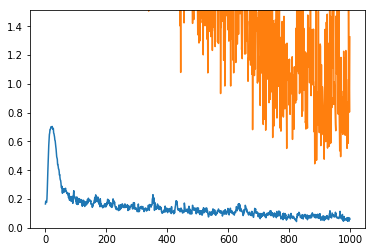

In [15]:
for i in range(500):
    train_rcn.next_batch(BATCH_SIZE)
    clear_output(True)
    current_max = np.max(train_rcn.get_variable('rcn_loss')[-20:])
    plt.plot(train_rcn.get_variable('rpn_loss'))
    plt.plot(train_rcn.get_variable('rcn_loss'))
    plt.ylim([0,current_max])
    plt.show()

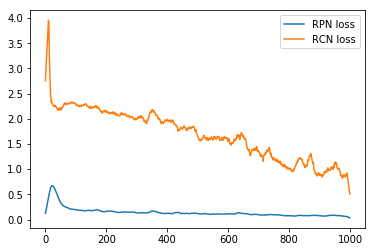

In [18]:
def smooth(y, box_pts=20):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

rpn_loss = train_rcn.get_variable('rpn_loss')
rcn_loss = train_rcn.get_variable('rcn_loss')
plt.plot(smooth(rpn_loss), label='RPN loss')
plt.plot(smooth(rcn_loss), label='RCN loss')
plt.legend()
plt.show()

In [19]:
test = (mnist.test.p
            .init_variable('rpn_reg', init_on_each_run=list)
            .init_variable('rpn_clsf', init_on_each_run=list)
            .init_variable('rcn_clsf', init_on_each_run=list)
            .import_model('FasterRCNN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=MNIST_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .predict_model('FasterRCNN', 
                          feed_dict=feed_dict_rcn, 
                          fetches=['roi', 'targets', 'rcn_output'], 
                          save_to=[V('rpn_reg'), V('rpn_clsf'), V('rcn_clsf')], mode='a'))

In [20]:
batch = test.next_batch(BATCH_SIZE)

In [21]:
roi = test.get_variable('rpn_reg')[-1]
targets = test.get_variable('rpn_clsf')[-1]
predictions = test.get_variable('rcn_clsf')[-1]

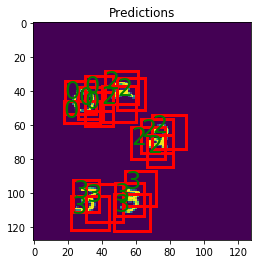

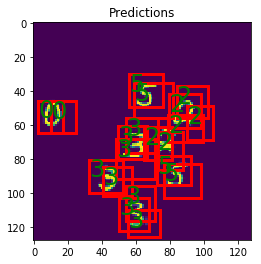

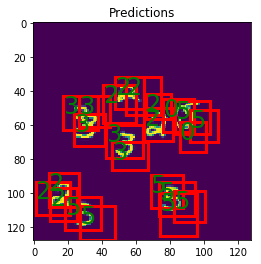

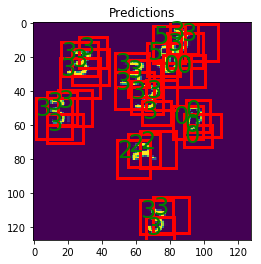

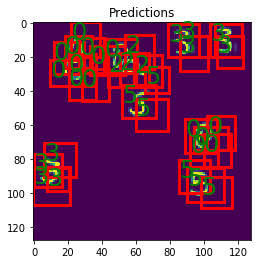

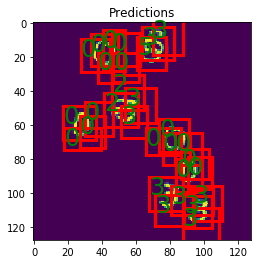

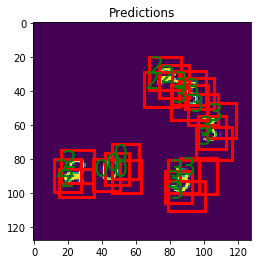

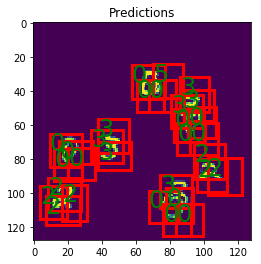

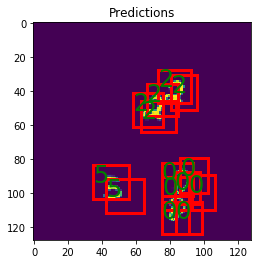

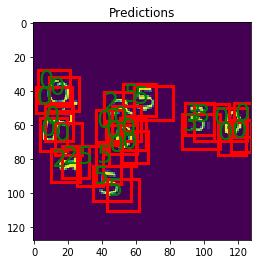

In [22]:
for i in range(BATCH_SIZE):
    im = batch.data.images[i, :, :, 0]
    bboxes = roi[i]
    
    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for j, bbox in enumerate(bboxes):      
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=3, edgecolor='r', facecolor='none')
        plt.text(bbox[1], bbox[0]+10, targets[i][j], color='g', size=24)
        ax.add_patch(rect)
        
    plt.title('Predictions')
    plt.show()